<a href="https://colab.research.google.com/github/Skyline-9/U2-Background-Removal/blob/main/U2_Background_Removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Based Background Removal Using U<sup>2</sup> - Net**
By Richard Luo

*Since: June 25, 2021*

Link to research article: https://arxiv.org/pdf/2005.09007.pdf


### **Verifying GPU**
Make sure GPU acceleration is enabled, preferably the T4 over the P1000.

In [1]:
!nvidia-smi

Tue Aug  3 05:13:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Mounting Google Drive**

In [31]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Introduction**
Salient Object Detection (SOD) is a task based on segmenting the most visually attractive objects in an image. Most SOD networks work based on using features extracted by existing backbones such as AlexNet, VGG, ResNet, ResNeXt, and DenseNet. However, the problem is that all of these backbones are originally designed for image classification, meaning they "extract
features that are representative of semantic meaning rather
than local details and global contrast information, which are
essential to saliency detection."

For the International Conference on Pattern Recognition (ICPR) 2020, Qin et al. proposed a novel network for SOD called U<sup>2</sup>-net that allows training from scratch and
achieves comparable or better performance than those
based on existing pre-trained backbones.

# **Training the network**
Download and setup the DUTS-TR dataset to train on

In [1]:
!mkdir -p data
!wget http://saliencydetection.net/duts/download/DUTS-TR.zip

--2021-08-03 05:39:28--  http://saliencydetection.net/duts/download/DUTS-TR.zip
Resolving saliencydetection.net (saliencydetection.net)... 36.55.239.177
Connecting to saliencydetection.net (saliencydetection.net)|36.55.239.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270997309 (258M) [application/zip]
Saving to: ‘DUTS-TR.zip’

DUTS-TR.zip         100%[===================>] 258.44M  1.91MB/s    in 2m 17s  

2021-08-03 05:41:45 (1.89 MB/s) - ‘DUTS-TR.zip’ saved [270997309/270997309]



Unzip the data

In [2]:
!unzip DUTS-TR.zip -d data

Streaming output truncated to the last 5000 lines.
 extracting: data/DUTS-TR/DUTS-TR-Mask/n07718747_3382.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n04270147_12691.png  
 extracting: data/DUTS-TR/DUTS-TR-Mask/n03211117_3402.png  
 extracting: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000680.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_val_00036949.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00033735.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n01644900_4125.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n04540053_2438.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n03770439_7684.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n07873807_5318.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00010870.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n03764736_1884.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n07742313_494.png  
 extracting: data/DUTS-TR/DUTS-TR-Mask/n03770439_218.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2013_test_00009085.png  

## **Writing the model**

In [28]:
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, ReLU, MaxPool2D, UpSampling2D


class ConvBlock(tf.keras.layers.Layer):
	"""Convolution 2D Block with a stride of 1 and same padding.

	Attributes:
		out_ch: Integer - Number of channels produced by the convolution
		dirate: Integer or tuple/list of 2 integers - Dilation rate to use for dilated convolution
	"""

	def __init__(self, out_ch=3, dirate=1):
		super(ConvBlock, self).__init__()

		# Layers
		self.conv = Conv2D(out_ch, (3, 3), strides=1, padding='same', dilation_rate=dirate)
		self.bn = BatchNormalization()
		self.relu = ReLU()

	def call(self, inputs):
		# Forward pass
		hx = inputs

		x = self.conv(hx)
		x = self.bn(x)
		x = self.relu(x)

		return x


class RSU_7(tf.keras.layers.Layer):
	"""RSU Block 7 (En_1 and De_1)

	Attributes:
		mid_ch: Integer - Number of mid channels
		out_ch: Integer - Number of channels produced by the convolution
	"""

	def __init__(self, mid_ch=12, out_ch=3):
		super(RSU_7, self).__init__()

		self.conv_b0 = ConvBlock(out_ch, dirate=1)

		# Conv_b1 to Conv_b5 are downsample x1/2
		self.conv_b1 = ConvBlock(mid_ch, dirate=1)
		self.pool1 = MaxPool2D(2, strides=(2, 2))

		self.conv_b2 = ConvBlock(mid_ch, dirate=1)
		self.pool2 = MaxPool2D(2, strides=(2, 2))

		self.conv_b3 = ConvBlock(mid_ch, dirate=1)
		self.pool3 = MaxPool2D(2, strides=(2, 2))

		self.conv_b4 = ConvBlock(mid_ch, dirate=1)
		self.pool4 = MaxPool2D(2, strides=(2, 2))

		self.conv_b5 = ConvBlock(mid_ch, dirate=1)
		self.pool5 = MaxPool2D(2, strides=(2, 2))

		# Downsample but no pool
		self.conv_b6 = ConvBlock(mid_ch, dirate=1)

		# Conv Block but Dilation=2
		self.conv_b7 = ConvBlock(mid_ch, dirate=2)

		# Same thing but with upsampling
		self.conv_b6_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b5_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b4_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b3_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b2_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b1_u = ConvBlock(out_ch, dirate=1)
		self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')

	def call(self, inputs):
		# Forward pass
		hx = inputs
		hxin = self.conv_b0(hx)

		# Downsampling
		hx1 = self.conv_b1(hxin)
		hx = self.pool1(hx1)

		hx2 = self.conv_b2(hx)
		hx = self.pool2(hx2)

		hx3 = self.conv_b3(hx)
		hx = self.pool3(hx3)

		hx4 = self.conv_b4(hx)
		hx = self.pool4(hx4)

		hx5 = self.conv_b5(hx)
		hx = self.pool5(hx5)

		hx6 = self.conv_b6(hx)

		hx7 = self.conv_b7(hx6)

		# Upsampling
		hx6u = self.conv_b6_u(tf.concat([hx7, hx6], axis=3))
		hx6u_up = self.upsample_5(hx6u)

		hx5u = self.conv_b5_u(tf.concat([hx6u_up, hx5], axis=3))
		hx5u_up = self.upsample_4(hx5u)

		hx4u = self.conv_b4_u(tf.concat([hx5u_up, hx4], axis=3))
		hx4u_up = self.upsample_3(hx4u)

		hx3u = self.conv_b3_u(tf.concat([hx4u_up, hx3], axis=3))
		hx3u_up = self.upsample_2(hx3u)

		hx2u = self.conv_b2_u(tf.concat([hx3u_up, hx2], axis=3))
		hx2u_up = self.upsample_1(hx2u)

		hx1u = self.conv_b1_u(tf.concat([hx2u_up, hx1], axis=3))

		return hx1u + hxin


class RSU_6(tf.keras.layers.Layer):
	"""RSU Block 6 (En_2 and De_2)

	Attributes:
		mid_ch: Integer - Number of mid channels
		out_ch: Integer - Number of channels produced by the convolution
	"""

	def __init__(self, mid_ch=12, out_ch=3):
		super(RSU_6, self).__init__()
		self.conv_b0 = ConvBlock(out_ch, dirate=1)

		self.conv_b1 = ConvBlock(mid_ch, dirate=1)
		self.pool1 = MaxPool2D(2, strides=(2, 2))

		self.conv_b2 = ConvBlock(mid_ch, dirate=1)
		self.pool2 = MaxPool2D(2, strides=(2, 2))

		self.conv_b3 = ConvBlock(mid_ch, dirate=1)
		self.pool3 = MaxPool2D(2, strides=(2, 2))

		self.conv_b4 = ConvBlock(mid_ch, dirate=1)
		self.pool4 = MaxPool2D(2, strides=(2, 2))

		self.conv_b5 = ConvBlock(mid_ch, dirate=1)
		self.pool5 = MaxPool2D(2, strides=(2, 2))

		self.conv_b6 = ConvBlock(mid_ch, dirate=2)

		# Upsample
		self.conv_b5_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b4_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b3_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b2_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b1_u = ConvBlock(out_ch, dirate=1)
		self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')

	def call(self, inputs):
		hx = inputs
		hxin = self.conv_b0(hx)

		# Downsampling
		hx1 = self.conv_b1(hxin)
		hx = self.pool1(hx1)

		hx2 = self.conv_b2(hx)
		hx = self.pool2(hx2)

		hx3 = self.conv_b3(hx)
		hx = self.pool3(hx3)

		hx4 = self.conv_b4(hx)
		hx = self.pool4(hx4)

		hx5 = self.conv_b5(hx)

		hx6 = self.conv_b6(hx5)

		# Upsampling
		hx5d = self.conv_b5_u(tf.concat([hx6, hx5], axis=3))
		hx5dup = self.upsample_4(hx5d)

		hx4d = self.conv_b4_u(tf.concat([hx5dup, hx4], axis=3))
		hx4dup = self.upsample_3(hx4d)

		hx3d = self.conv_b3_u(tf.concat([hx4dup, hx3], axis=3))
		hx3dup = self.upsample_2(hx3d)

		hx2d = self.conv_b2_u(tf.concat([hx3dup, hx2], axis=3))
		hx2dup = self.upsample_1(hx2d)

		hx1d = self.conv_b1_u(tf.concat([hx2dup, hx1], axis=3))

		return hx1d + hxin


class RSU_5(tf.keras.layers.Layer):
	"""RSU Block 5 (En_4 and De_4)

	Attributes:
		mid_ch: Integer - Number of mid channels
		out_ch: Integer - Number of channels produced by the convolution
	"""

	def __init__(self, mid_ch=12, out_ch=3):
		super(RSU_5, self).__init__()
		self.conv_b0 = ConvBlock(out_ch, dirate=1)

		self.conv_b1 = ConvBlock(mid_ch, dirate=1)
		self.pool1 = MaxPool2D(2, strides=(2, 2))

		self.conv_b2 = ConvBlock(mid_ch, dirate=1)
		self.pool2 = MaxPool2D(2, strides=(2, 2))

		self.conv_b3 = ConvBlock(mid_ch, dirate=1)
		self.pool3 = MaxPool2D(2, strides=(2, 2))

		self.conv_b4 = ConvBlock(mid_ch, dirate=1)
		self.pool4 = MaxPool2D(2, strides=(2, 2))

		self.conv_b5 = ConvBlock(mid_ch, dirate=2)

		# Upsample
		self.conv_b4_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b3_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b2_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b1_u = ConvBlock(out_ch, dirate=1)
		self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')

	def call(self, inputs):
		# Forward pass
		hx = inputs
		hxin = self.conv_b0(hx)

		hx1 = self.conv_b1(hxin)
		hx = self.pool1(hx1)

		hx2 = self.conv_b2(hx)
		hx = self.pool2(hx2)

		hx3 = self.conv_b3(hx)
		hx = self.pool3(hx3)

		hx4 = self.conv_b4(hx)

		hx5 = self.conv_b5(hx4)

		hx4u = self.conv_b4_u(tf.concat([hx5, hx4], axis=3))
		hx4u_up = self.upsample_3(hx4u)

		hx3u = self.conv_b3_u(tf.concat([hx4u_up, hx3], axis=3))
		hx3u_up = self.upsample_2(hx3u)

		hx2u = self.conv_b2_u(tf.concat([hx3u_up, hx2], axis=3))
		hx2u_up = self.upsample_1(hx2u)

		hx1u = self.conv_b1_u(tf.concat([hx2u_up, hx1], axis=3))

		return hx1u + hxin


class RSU_4(tf.keras.layers.Layer):
	"""RSU Block 4 (En_5 and De_5)

	Attributes:
		mid_ch: Integer - Number of mid channels
		out_ch: Integer - Number of channels produced by the convolution
	"""

	def __init__(self, mid_ch=12, out_ch=3):
		super(RSU_4, self).__init__()
		self.conv_b0 = ConvBlock(out_ch, dirate=1)

		self.conv_b1 = ConvBlock(mid_ch, dirate=1)
		self.pool1 = MaxPool2D(2, strides=(2, 2))

		self.conv_b2 = ConvBlock(mid_ch, dirate=1)
		self.pool2 = MaxPool2D(2, strides=(2, 2))

		self.conv_b3 = ConvBlock(mid_ch, dirate=1)
		self.pool3 = MaxPool2D(2, strides=(2, 2))

		self.conv_b4 = ConvBlock(mid_ch, dirate=2)

		# Upsample
		self.conv_b3_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b2_u = ConvBlock(mid_ch, dirate=1)
		self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.conv_b1_u = ConvBlock(out_ch, dirate=1)
		self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')

	def call(self, inputs):
		# Forward pass
		hx = inputs
		hxin = self.conv_b0(hx)

		hx1 = self.conv_b1(hxin)
		hx = self.pool1(hx1)

		hx2 = self.conv_b2(hx)
		hx = self.pool2(hx2)

		hx3 = self.conv_b3(hx)
		hx4 = self.conv_b4(hx3)

		hx3u = self.conv_b3_u(tf.concat([hx4, hx3], axis=3))
		hx3u_up = self.upsample_2(hx3u)

		hx2u = self.conv_b2_u(tf.concat([hx3u_up, hx2], axis=3))
		hx2u_up = self.upsample_1(hx2u)

		hx1u = self.conv_b1_u(tf.concat([hx2u_up, hx1], axis=3))

		return hx1u + hxin


class RSU_4F(tf.keras.layers.Layer):
	"""RSU Block 4F (En_5, En_6, De_5)

	Attributes:
		mid_ch: Integer - Number of mid channels
		out_ch: Integer - Number of channels produced by the convolution
	"""

	def __init__(self, mid_ch=12, out_ch=3):
		super(RSU_4F, self).__init__()
		self.conv_b0 = ConvBlock(out_ch, dirate=1)
		self.conv_b1 = ConvBlock(mid_ch, dirate=1)

		self.conv_b2 = ConvBlock(mid_ch, dirate=2)
		self.conv_b3 = ConvBlock(mid_ch, dirate=4)

		self.conv_b4 = ConvBlock(mid_ch, dirate=8)

		self.conv_b3_d = ConvBlock(mid_ch, dirate=4)
		self.conv_b2_d = ConvBlock(mid_ch, dirate=2)

		self.conv_b1_d = ConvBlock(out_ch, dirate=1)

	def call(self, inputs):
		# Forward pass
		hx = inputs
		hxin = self.conv_b0(hx)

		hx1 = self.conv_b1(hxin)
		hx2 = self.conv_b2(hx1)
		hx3 = self.conv_b3(hx2)
		hx4 = self.conv_b4(hx3)

		hx3d = self.conv_b3_d(tf.concat([hx4, hx3], axis=3))
		hx2d = self.conv_b2_d(tf.concat([hx3d, hx2], axis=3))
		hx1d = self.conv_b1_d(tf.concat([hx2d, hx1], axis=3))

		return hx1d + hxin


class U2NET(tf.keras.models.Model):
	"""
	Full sized U2 model
	"""

	def __init__(self, out_ch=1):
		super(U2NET, self).__init__()

		# Encoder
		self.stage1 = RSU_7(32, 64)
		self.pool12 = MaxPool2D((2, 2), 2)

		self.stage2 = RSU_6(32, 128)
		self.pool23 = MaxPool2D((2, 2), 2)

		self.stage3 = RSU_5(64, 256)
		self.pool34 = MaxPool2D((2, 2), 2)

		self.stage4 = RSU_4(128, 512)
		self.pool45 = MaxPool2D((2, 2), 2)

		self.stage5 = RSU_4F(256, 512)
		self.pool56 = MaxPool2D((2, 2), 2)

		self.stage6 = RSU_4F(256, 512)

		# Decoder
		self.stage5d = RSU_4F(256, 512)
		self.stage4d = RSU_4(128, 256)
		self.stage3d = RSU_5(64, 128)
		self.stage2d = RSU_6(32, 64)
		self.stage1d = RSU_7(16, 64)

		self.side1 = Conv2D(out_ch, (3, 3), padding='same')
		self.side2 = Conv2D(out_ch, (3, 3), padding='same')
		self.side3 = Conv2D(out_ch, (3, 3), padding='same')
		self.side4 = Conv2D(out_ch, (3, 3), padding='same')
		self.side5 = Conv2D(out_ch, (3, 3), padding='same')
		self.side6 = Conv2D(out_ch, (3, 3), padding='same')

		self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
		self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
		self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
		self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
		self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
		self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')

		self.upsample_out_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
		self.upsample_out_3 = UpSampling2D(size=(4, 4), interpolation='bilinear')
		self.upsample_out_4 = UpSampling2D(size=(8, 8), interpolation='bilinear')
		self.upsample_out_5 = UpSampling2D(size=(16, 16), interpolation='bilinear')
		self.upsample_out_6 = UpSampling2D(size=(32, 32), interpolation='bilinear')

		self.outconv = Conv2D(out_ch, (1, 1), padding='same')

	def call(self, inputs):
		hx = inputs

		# Stage 1
		hx1 = self.stage1(hx)
		hx = self.pool12(hx1)

		# Stage 2
		hx2 = self.stage2(hx)
		hx = self.pool23(hx2)

		# Stage 3
		hx3 = self.stage3(hx)
		hx = self.pool34(hx3)

		# Stage 4
		hx4 = self.stage4(hx)
		hx = self.pool45(hx4)

		# Stage 5
		hx5 = self.stage5(hx)
		hx = self.pool56(hx5)

		# stage 6
		hx6 = self.stage6(hx)
		hx6up = self.upsample_1(hx6)
		side6 = self.upsample_out_6(self.side6(hx6))

		# Decoder and side output
		hx5d = self.stage5d(tf.concat([hx6up, hx5], axis=3))
		hx5dup = self.upsample_2(hx5d)
		side5 = self.upsample_out_5(self.side5(hx5d))

		hx4d = self.stage4d(tf.concat([hx5dup, hx4], axis=3))
		hx4dup = self.upsample_3(hx4d)
		side4 = self.upsample_out_4(self.side4(hx4d))

		hx3d = self.stage3d(tf.concat([hx4dup, hx3], axis=3))
		hx3dup = self.upsample_4(hx3d)
		side3 = self.upsample_out_3(self.side3(hx3d))

		hx2d = self.stage2d(tf.concat([hx3dup, hx2], axis=3))
		hx2dup = self.upsample_5(hx2d)
		side2 = self.upsample_out_2(self.side2(hx2d))

		hx1d = self.stage1d(tf.concat([hx2dup, hx1], axis=3))
		side1 = self.side1(hx1d)

		fused_output = self.outconv(tf.concat([side1, side2, side3, side4, side5, side6], axis=3))

		sig = tf.keras.activations.sigmoid
		return tf.stack([sig(fused_output), sig(side1), sig(side2), sig(side3), sig(side4), sig(side5), sig(side6)])

## **Writing the loss function**
[The paper](https://arxiv.org/pdf/2005.09007.pdf) defines the loss function as the sum of the binary crossentropy between each of the 6 sides and the ground truth, and the fused output and the ground truth, for a total of 7 equally weighted BCE terms:

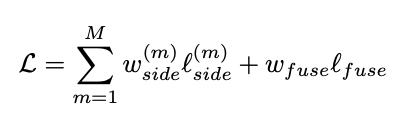

For each term <code>l</code>, we use the standard binary crossentropy to calculate the loss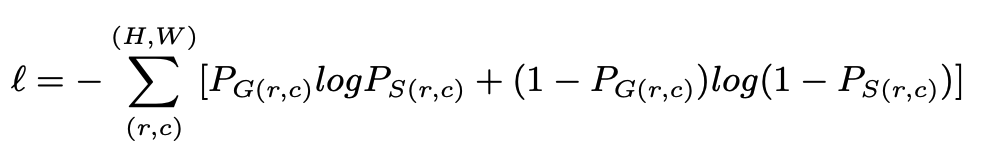

In [5]:
bce = tf.keras.losses.BinaryCrossentropy()


def loss(y_true, y_pred):
    # Add inner most dimension
    y_pred = tf.expand_dims(y_pred, axis=-1)
    return sum(bce(y_true, y_pred[i]) for i in range(0, 7))

## **Define Config Variables**

In [6]:
import pathlib

# Model
default_in_shape = (320, 320, 3)
default_out_shape = (320, 320, 1)
checkpoint_path = 'weights.ht5'

# Training
batch_size = 8
epochs = 5000
learning_rate = 0.001
eval_interval = 100
weights_save_interval = 500

# Dataset 
root_data_dir = pathlib.Path('data')
dataset_dir = root_data_dir.joinpath('DUTS-TR')
image_dir = dataset_dir.joinpath('DUTS-TR-Image')
mask_dir = dataset_dir.joinpath('DUTS-TR-Mask')

# Model type
# By default, the regular sized model (U2NET) is used in this notebook.
# Set this to True if you want to use the condensed model (U2NETP)
use_tiny_model = False

## **Define Dataloader**

In [7]:
# Dataloader methods (dataloader.py)

import os
import random
import numpy as np
import zipfile

from PIL import Image 

input_files = os.listdir(image_dir)

def get_image_mask_pair(img_name, in_resize=None, out_resize=None):
    img  = Image.open(image_dir.joinpath(img_name))
    mask = Image.open(mask_dir.joinpath(img_name.replace('jpg', 'png')))

    if in_resize:
        img = img.resize(in_resize[:2], Image.BICUBIC)
    
    if out_resize:
        mask = mask.resize(out_resize[:2], Image.BICUBIC)
    
    if bool(random.getrandbits(1)):
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

    return (np.asarray(img, dtype=np.float32), np.expand_dims(np.asarray(mask, dtype=np.float32), -1))

def load_training_batch(batch_size=12, in_shape=default_in_shape, out_shape=default_out_shape):
    imgs = random.choices(input_files, k=batch_size)
    image_list = [get_image_mask_pair(img, in_resize=default_in_shape, out_resize=default_out_shape) for img in imgs]
    
    tensor_in  = np.stack([i[0]/255. for i in image_list])
    tensor_out = np.stack([i[1]/255. for i in image_list])
    
    return (tensor_in, tensor_out)

## **Build the model**
Build and compile the model with Adam optimizer

In [29]:
# Build the network
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=.9, beta_2=.999, epsilon=1e-08)
inputs = tf.keras.Input(shape=default_in_shape)
net = U2NET()
out = net(inputs)
model = tf.keras.Model(inputs=inputs, outputs=out, name='u2netmodel')
model.compile(optimizer=adam, loss=loss, metrics=None)

# Print summary
model.summary()

Model: "u2netmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 320, 320, 3)]     0         
_________________________________________________________________
u2net_10 (U2NET)             (7, None, 320, 320, 1)    44038669  
Total params: 44,038,669
Trainable params: 44,009,869
Non-trainable params: 28,800
_________________________________________________________________


## **Convert PIL image into tensor**

In [32]:
import cv2
import io
import base64
from IPython.display import HTML
import matplotlib.pyplot as plt
from google.colab import files


def format_input(input_image):
  assert(input_image.size == default_in_shape[:2] or input_image.shape == default_in_shape)
  return np.expand_dims(np.array(input_image)/255., 0)


# Load test image
im = Image.open('space.jpeg')
im = im.resize(default_in_shape[:2])
image = format_input(im)

## Train Model

[0] Loss: 6.340705871582031


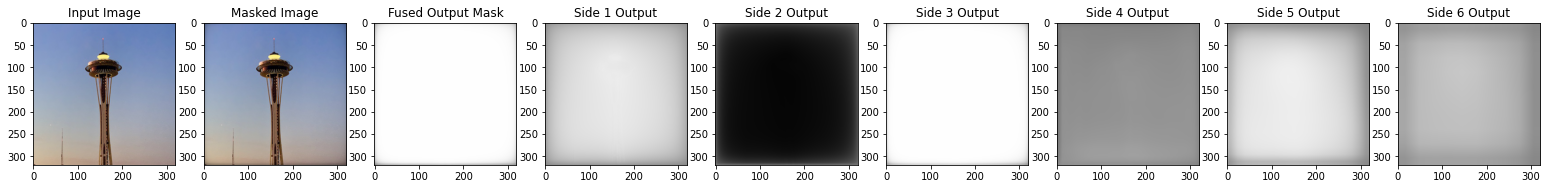

[100] Loss: 2.6552231311798096


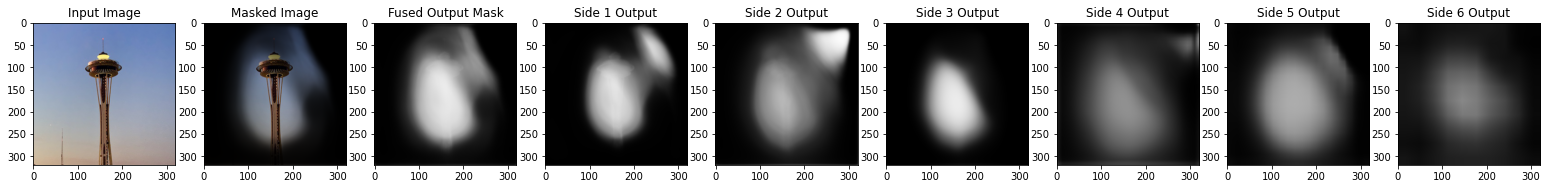

In [ ]:
for e in range(epochs):
    try:
      feed, out = load_training_batch(batch_size=batch_size)
      loss = model.train_on_batch(feed, out)

      if e % weights_save_interval == 0:
        model.save(checkpoint_path)

      if e % eval_interval == 0:
        print('[%s] Loss: %s' % (e, str(loss)))
        out = model(image)
        f, a = plt.subplots(1,9,figsize=(27, 3))
        a[0].imshow(image[0])
        a[1].imshow(np.multiply(image[0], np.tile(out[0][0], [1, 1, 3])))
        a[2].imshow(np.tile(out[0][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[3].imshow(np.tile(out[1][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[4].imshow(np.tile(out[2][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[5].imshow(np.tile(out[3][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[6].imshow(np.tile(out[4][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[7].imshow(np.tile(out[5][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[8].imshow(np.tile(out[6][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)

        a[0].set_title('Input Image')
        a[1].set_title('Masked Image')
        a[2].set_title('Fused Output Mask')
        for i, ax in enumerate(a[3:]):
          ax.set_title('Side %d Output' % (i+1))
          
        plt.show()
    except KeyboardInterrupt:
      pass
    except ValueError:
      pass